Determine Roche radii of the cores and other few things

In [1]:
from MESAreader import *
import matplotlib.pyplot as plt


In [2]:
root = "/mnt/ceph/users/mrenzo/RUNS/Radii_RSG_cores/"
folders = glob.glob(root+'/*/')
# print(folders)

def getM(f):
    return float(f.split('cores/')[-1].rstrip('/'))

def get_t_kh(L,R,M):
    global G_cgs, Msun, Rsun_cm, Lsun, secyer # these are from $MESA_DIR/const/public/const_def.f90
    # convert to cgs
    M *= Msun
    R *= Rsun_cm
    L *= Lsun
    # same formula coded in MESA, 0.75 geometric factor
    t_kh = 0.75*G_cgs*M*M/(R*L) # sec
    t_kh = t_kh/secyer # years
    return t_kh


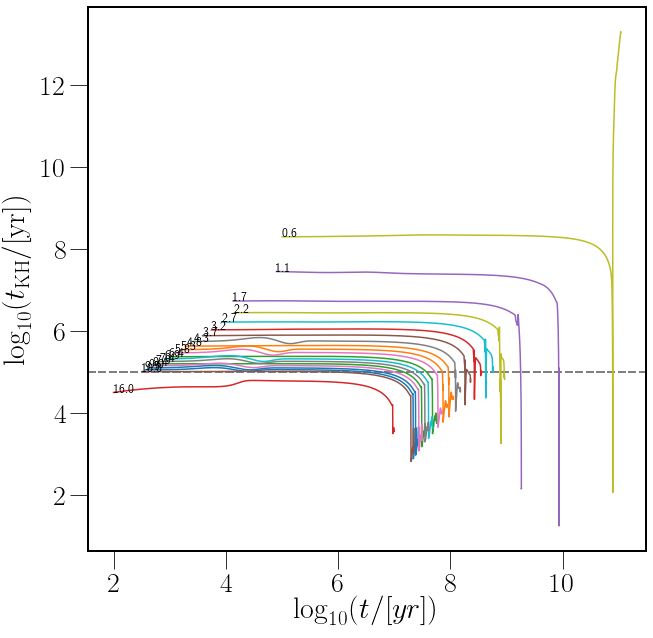

In [34]:
# plot KH timescale as a function of time for a grid of models

fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100)
gs.update(wspace=0,hspace=0)
ax = plt.subplot(gs[:,:])

ax.set_xlabel(r"$\log_{10}(t / [yr])$",fontsize=30)
ax.set_ylabel(r"$\log_{10}(t_\mathrm{KH}/\mathrm{[yr]})$",fontsize=30)

for f in folders:
    if getM(f) != 0.1:
        src, col = getSrcCol(f+'LOGS/history.data', True, True)
        R = 10**(src[:, col.index('log_R')]) # Rsun units
        M = src[:, col.index("star_mass")] #Msun
        L = 10**(src[:, col.index("log_L")]) #Lsun
        t = src[:, col.index("star_age")]
        t_kh = get_t_kh(L,R,M)
        ax.plot(np.log10(t), np.log10(t_kh))
        ax.text(np.log10(t[0]),np.log10(t_kh)[0], "%.1f"%getM(f), fontsize=12, transform=ax.transData)
        ax.axhline(5,0,1,lw='2',ls='--',c='#808080',zorder=0)


In [4]:
## Eggleton 1983 Formula

def func(q):
    return ((0.49*q**(2/3.0))/(0.6*q**(2/3.0)+np.log(1+q**(1/3.0))))


def Roche_radius(q, a):
    # Eggleton 1983 formula for Roche Lobe
    # q = M1/M2
    # rl1 = a*((0.49*q**(2/3.0))/(0.6*q**(2/3.0)+np.log(1+q**(1/3.0))))
    # q = M2/M1
    rl = a*func(q)
    return rl


def acrit(Rcore, q):
    # returns separation a such that R_core = R_roche_lobe_core corresponding to the merger
    # Egglenton's formula
    # R_roche_lobe_core = a*f(q) => a = R_roche_lobe_core/f(q) => acrit = R_core/f(q)

    return Rcore/func(q)
    
def get_fgw_from_sep_mass(M1, M2, a):
    ## assumes masses in solar masses and separation in solar radii
    # v = omega*a
    # omega^2 a^3 = G(M1+M2) # 3rd Kepler's law
    #omega = sqrt(G(M1+M2)/a^3)
    # P = 24/omega
    omega = np.sqrt((G_cgs*(M1+M2)*Msun)/(a*Rsun_cm)**3)
    omega_GW = 2*omega
    # P = 2*math.pi/omega # in sec
    # Pdays = P/86400 # in days
    
    # print("omega=",omega, "Hz")
    # print("omega_GW", omega_GW, "Hz")
    return omega_GW

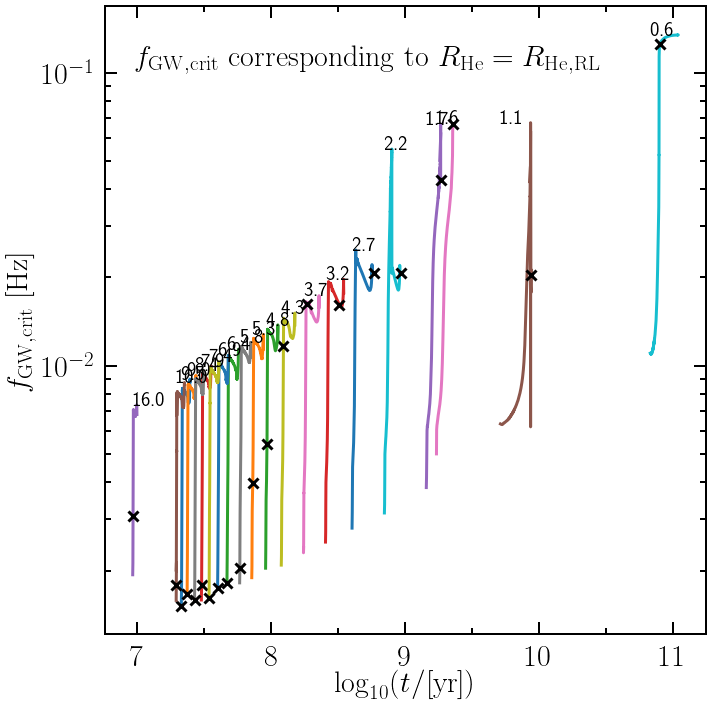

In [14]:
# critical GW frequency as a function of time for all masses I have
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(10,10)
ax = plt.subplot(gs[:,:])

Mcompanion = 0.3 #Msun, assuming a WD

for f in folders:
    M = getM(f)
    if M != 0.1:
        src, col = getSrcCol(f+'LOGS/history.data', True, True)
        he_core_mass = src[:, col.index("he_core_mass")]
        ind = he_core_mass != 0
        he_core_mass = he_core_mass[ind]
        he_core_radius = src[ind, col.index("he_core_radius")]
        t = np.log10(src[ind, col.index("star_age")])

        a_cr = acrit(he_core_radius,he_core_mass/Mcompanion)
        f_gw_crit = get_fgw_from_sep_mass(he_core_mass, Mcompanion, a_cr)
        ax.plot(t,f_gw_crit, lw=3)

        i = np.argmin(np.absolute(he_core_mass - 0.5))
        time = t[i]
        critf = get_fgw_from_sep_mass(he_core_mass[i], Mcompanion, acrit(he_core_radius[i],he_core_mass[i]/Mcompanion))
        ax.plot(time, critf,marker='x', ms=10, c='k', mew=3)
        
        ax.text(t[0],max(f_gw_crit), "%.1f"%getM(f), fontsize=20, transform=ax.transData)

ax.set_yscale('log')
ax.tick_params(axis='both', which='major', width=2, top="on", right="on", length=12, pad=10, labelsize=30, direction='in')
ax.tick_params(axis='both', which='minor', width=2, top="on", right="on", length=6, pad=10, labelsize=30, direction='in')
ax.set_xlabel(r"$\log_{10}(t / [\mathrm{yr}])$",fontsize=30)
ax.set_ylabel(r"$f_\mathrm{GW,crit}\ [\mathrm{Hz}]$", fontsize=30)
ax.text(0.05,0.9,r"$f_\mathrm{GW,crit} \ \mathrm{corresponding\ to} \ R_\mathrm{He} = R_\mathrm{He, RL}$", transform=ax.transAxes,fontsize=30)
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))

plt.tight_layout()
plt.savefig("/mnt/home/mrenzo/TMP/CE_LISA/f_GW_crit.pdf",dpi=300)

# ax.text(0.05,0.85,r"$\mathrm{assuming} \ M_2=0.3\,M_\odot)$", transform=ax.transAxes,fontsize=30)

/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:49: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


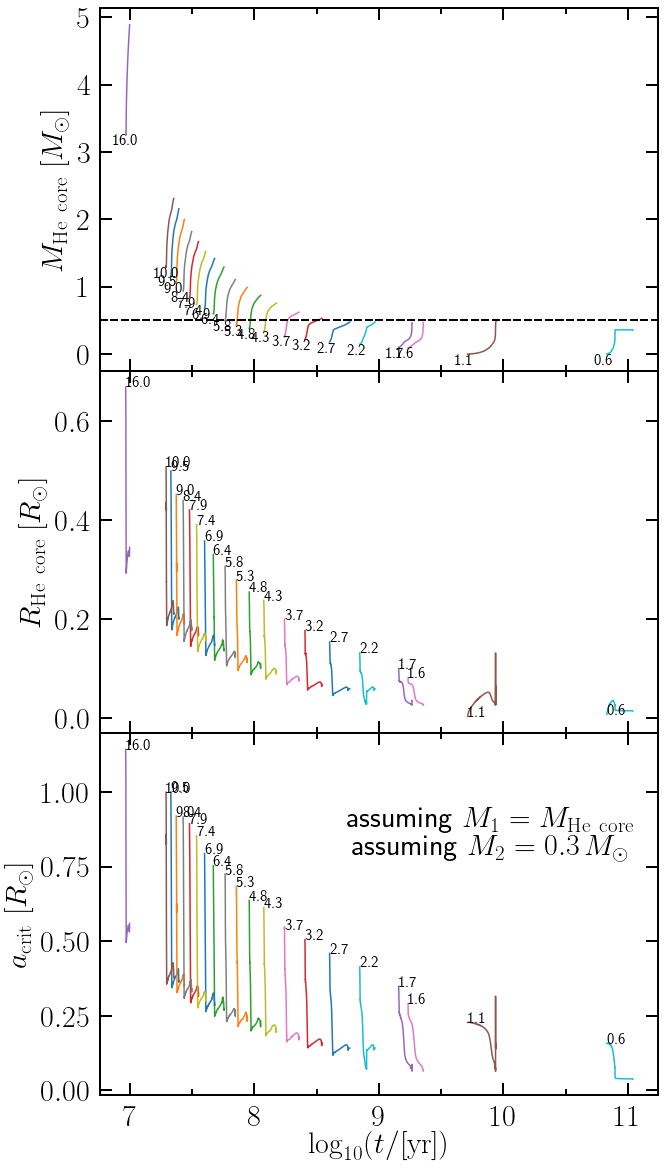

In [6]:
# print M_he as a function of time
fig = plt.figure(figsize=(10., 20.))
gs = gridspec.GridSpec(120,120)
gs.update(wspace=0,hspace=0)# top=1.1)
ax = plt.subplot(gs[:40,:])
bx = plt.subplot(gs[40:80,:])
cx = plt.subplot(gs[80:,:])

for axis in [ax,bx,cx]:
    axis.tick_params(axis='both', which='major', width=2, top="on", right="on",
               length=12, pad=10, labelsize=30, direction='in')
    axis.tick_params(axis='both', which='minor', width=2, top="on", right="on",
                     length=6, pad=10, direction='in')

    axis.xaxis.set_major_locator(MultipleLocator(1))
    axis.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.yaxis.set_major_locator(MultipleLocator(5))
# ax.yaxis.set_minor_locator(MultipleLocator(1))


cx.set_xlabel(r"$\log_{10}(t / [\mathrm{yr}])$",fontsize=30)
ax.set_ylabel(r"$M_\mathrm{He\ core} \ [M_\odot]$",fontsize=30)
bx.set_ylabel(r"$R_\mathrm{He\ core} \ [R_\odot]$",fontsize=30)
cx.set_ylabel(r"$a_\mathrm{crit} \ [R_\odot]$",fontsize=30)

for f in folders:
    if getM(f) != 0.1:
        src, col = getSrcCol(f+'LOGS/history.data', True, True)
        he_core_mass = src[:, col.index("he_core_mass")]
        ind = he_core_mass != 0
        he_core_mass = he_core_mass[ind]
        he_core_radius = src[ind, col.index("he_core_radius")]
        t = np.log10(src[ind, col.index("star_age")])
        
        ax.text(t[0]-0.1,he_core_mass[0]-0.15, "%.1f"%getM(f), fontsize=15, transform=ax.transData)
        ax.axhline(0.5,0,1,lw='2',ls="--",c='k')
        bx.text(t[0],he_core_radius[0], "%.1f"%getM(f), fontsize=15, transform=bx.transData)
        cx.text(t[0],acrit(he_core_radius,he_core_mass/0.3)[0], "%.1f"%getM(f), fontsize=15, transform=cx.transData)      
        
        ax.plot(t, he_core_mass)
        bx.plot(t, he_core_radius)
        ## assume a WD companion of 0.3Msun
        cx.plot(t, acrit(he_core_radius,he_core_mass/0.3))
 

cx.text(0.7,0.75,"assuming  $M_1 = M_\mathrm{He\ core}$", va="center", ha="center", fontsize=30, transform=cx.transAxes)
cx.text(0.7,0.67,"assuming $M_2=0.3\,M_\odot$", va="center", ha="center", fontsize=30, transform=cx.transAxes)
#ax.text(0.7,0.75,"assuming $M2=0.3\,M_\odot$", va="center", ha="center", fontsize=30, transform=ax.transAxes)
plt.tight_layout()
plt.savefig(root+"/core_masses_RLOBE.pdf")
        

In [69]:
def snr_from_a_adot(a0,adot, m=1.0):
    ## copy pasted from Tom's notebook on March 9th
    # -------------------------------------
    ## adapted to read my constants though
    global Rsun_cm, secyer, G_cgs
    Rsun = Rsun_cm
    year = secyer
    G = G_cgs
    kpc = 1e3*3.086e16
    c = 2.998e8
    # the total mass is now passed as a parameter to this function
    # ------------------------------------
    a0 = Rsun*a0
    adot = adot*Rsun/year

    # Separation (s)
    D = 3*kpc
    a_final = max(0.0*Rsun,a0+adot*5.*year)

    # Binary mass
    kg_to_sec = G/c**3.
    m = 1.*Msun

    # GW frequencies
    f0 = (1./np.pi)*np.sqrt(G*m/a0**3.)
    if a_final==0:
        f_final = 10.
    else:
        f_final = (1./np.pi)*np.sqrt(G*m/a_final**3.)
    
    # Get fourier-domain amplitudes
    fourier_freqs = np.arange(f0,f_final,(f_final-f0)/100.)
    amp_at_f = (4./D)*np.power(G*Msun/c**2.,5./3.)*np.power(np.pi*fourier_freqs/c,2./3.)
    sep_at_f = np.power(G*Msun/(np.pi*fourier_freqs)**2,1./3.)
    fdot_at_f = -(3./(2.*np.pi))*np.sqrt(G*Msun)*np.power(sep_at_f,-5./2.)*(adot)
    hf = amp_at_f/np.sqrt(fdot_at_f)

    PSD = LISA_sensitivity(fourier_freqs)
    rho2 = (16./5.)*np.trapz(np.power(hf,2.)/PSD,fourier_freqs)
    
    return np.sqrt(rho2)/4



L_arm = 2.5e9
fref = 19.09e-3
def LISA_sensitivity(f):
    
    # Instrumental noise
    P_oms = np.power(1.5e-11,2.)*(1.+np.power(2.e-3/f,4.))
    P_acc = np.power(3.e-15,2.)*(1.+np.power(0.4e-3/f,2.))*(1.+np.power(f/8e-3,4))
    #P_n = P_oms/L_arm**2. + 2.*(1.+np.cos(f/fref)**2.)*P_acc/(np.power(2.*np.pi*f,4.)*L_arm**2.)    
    S_n = (10./(3.*L_arm*L_arm))*(P_oms + 4.*P_acc/np.power(2.*np.pi*f,4.))*(1.+(3./5.)*np.power(f/fref,2.))
    
    # Confusion noise (assume four years)
    A = 9e-45
    alpha = 0.138
    beta = -221.
    k = 521.
    gamma = 1680.
    fk = 1.13e-3
    S_conf = A*np.power(f,-7./3.)*np.exp(-f**alpha+beta*f*np.sin(k*f))*(1.+np.tanh(gamma*(fk-f)))
    
    S_n[f>=1.] = np.inf
    S_conf[f>=1.] = np.inf
    
    return S_n + S_conf



/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: overflow encountered in exp
/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply
/mnt/home/mrenzo/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


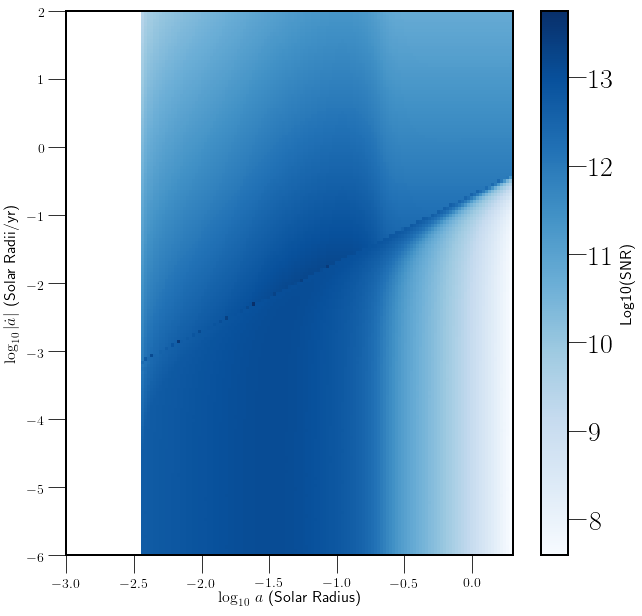

In [60]:
a_orbs = np.linspace(-3.,0.3,150)
adot_orbs = np.linspace(-6,2,160)
rhos = np.zeros((a_orbs.size,adot_orbs.size))
for i in range(a_orbs.size):
    for j in range(adot_orbs.size):
        rhos[i,j] = snr_from_a_adot(10.**a_orbs[i],-10.**adot_orbs[j])

fig,ax = plt.subplots(figsize=(10,10))
PS = ax.pcolormesh(a_orbs,adot_orbs,np.log10(rhos).T,cmap='Blues')
#CS = ax.contour(a_orbs,adot_orbs,rhos.T,levels=[1,10,100],colors='black')
ax.clabel(CS, inline=1, fontsize=14)
ax.set_xlabel(r'$\log_{10} \,a$ (Solar Radius)',fontsize=16)
ax.set_ylabel(r'$\log_{10} |\dot a|$ (Solar Radii/yr)',fontsize=16)
ax.tick_params(labelsize=14)
cb = fig.colorbar(PS)
cb.set_label(label="Log10(SNR)",fontsize=16)
#plt.savefig('./SNRs.pdf')
